#### Importing the Modules

In [2]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

%matplotlib inline

#### Configuration

In [3]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.to("cpu")
model.eval()
classes = load_classes(class_path)
Tensor = torch.FloatTensor

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

#### Algorithm for Detecting Boundaries

In [4]:
#global list to hold the points
points =  []
refPt = []
drawing = False
def click_draw(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, drawing
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        drawing = True
    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        drawing = False
        # draw a rectangle around the region of interest
        cv2.line(image, refPt[0], refPt[1], (0, 255, 0), 2)
        cv2.imshow("image", image)

#### Football Field

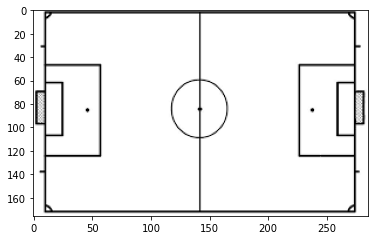

In [5]:
img_dst = cv2.imread('field.png');
plt.imshow(img_dst)

dst_pts = np.array([
    [0,350],
    [315,350],
    [615,350],
    [615,175],
    [615,0],
    [315,0],
    [0,0],
    [0,175]
    ]) 

im_poly = img_dst.copy()

cv2.polylines(im_poly, [dst_pts], isClosed=True, color=[255,0,0], thickness=2)

cv2.imshow("polylines", im_poly);cv2.waitKey();cv2.destroyAllWindows()

**Run the below algorithm 4 times**

In [1]:
# load the image, clone it, and setup the mouse callback function`
image = cv2.imread('img_0.jpg')
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_draw)
# keep looping until the 'q' key is pressed
while True:
    # display the image and wait for a keypress
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("r"):
        image = clone.copy()
    # if the 'c' key is pressed, break from the loop
    elif key == ord("c"):
        points.append(refPt)
        break
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [7]:
# drawing the lines in the image
for point in points:
    print(point[0])
    cv2.line(image,point[0],point[1],(0,255,0),2)
while True:
    # display the image and wait for a keypress
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cv2.destroyAllWindows()

(27, 19)


In [12]:
img = cv2.imread('img_0.jpg')
src_pts = np.array([
    [81,280],
    [234,459],
    [862,1048],
    [1509,647],
    [1723,469],
    [1210,337],
    [618,227],
    [385,245],
    ])   

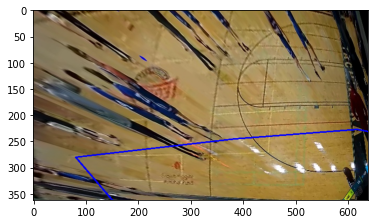

In [24]:
im_poly = img.copy()

cv2.polylines(im_poly, [src_pts], isClosed=True, color=[255,0,0], thickness=2)

cv2.imshow("polylines", im_poly);cv2.waitKey();cv2.destroyAllWindows()

rgb = cv2.cvtColor(im_poly, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

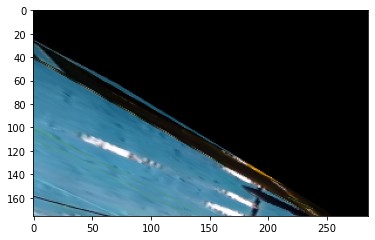

In [13]:
def warpCourt(img):
    """
    Transformation
    """
    h, status = cv2.findHomography(src_pts, dst_pts)
    img_out = cv2.warpPerspective(img, h, (img_dst.shape[1], img_dst.shape[0]))
    return img_out
    #plt.imshow(img_out)
plt.imshow(warpCourt(img))

#### Detection for teams

In [14]:
import cv2

def getUniqueColors(img):
    '''
    input: any image
    output: unique color values and its count
    job: find out all the unique color values and its count
        in a given image1
    '''
    a = np.copy(img[:,:,:])
    x = np.split(a.ravel(),img.shape[0]*img.shape[1])
    color,color_count = np.unique(x,return_counts= True,axis = 0)
    return color, color_count

def percentageOfColor(img,black = True):
    '''
    add something here tomorrow
    '''
    color,colorcount = getUniqueColors(img)
    black_count = colorcount[0] # black is the lowest color
    percentage_of_black = black_count/(img.shape[0]*img.shape[1])
    if black:
        return percentage_of_black*100
    else:
        return (1 - percentage_of_black)*100
    
    
def color_check(img,color_name='blue'):
    colors = {'blue':
          {'low':np.array([24, 141, 74]),
           'high':np.array([40, 255, 255])
          },'red':
          {
          'low':np.array([71, 54, 0]),
          'high':np.array([180, 154, 255])
          },'green':
          {
           'low':np.array([25,52,72]),
            'high':np.array([102,255,255])
          },'white':
            {
            'low':np.array([171,151,0]),
            'high':np.array([180,255,255])
            }
         }    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    try:
        high = colors[color_name]['high']
        low = colors[color_name]['low']        
    except Exception as e:
        print(f"{e}: color not expected")
        raise NotImplementedError
        
    mask = cv2.inRange(hsv, low, high)
    result = cv2.bitwise_and(img, img, mask=mask)
    return percentageOfColor(result,False)

def colorselector(img,teamcolors):
    '''
    teamcolors = ['blue','white','red']
    index 0 -> team1
    index 1 -> team2
    index 2 -> refree
    teamcolors[posistion]
    '''
    color = [[100,100,0],[0,0,100],[255,0,0]]
    cls = ''
    bestcolor = [color_check(img,i) for i in teamcolors]
    posistion = bestcolor.index(max(bestcolor))
    if posistion == 2:
        cls = 'refree'
    else:
        cls = f"team{posistion+1}"
    return color[posistion],cls

In [15]:
dict_heatmaps = {'team1':[],'team2':[], 'refree': []}

#### Checking if points are inside the rectangle (boundary)

In [16]:
def vector(p1,p2):
    return {'x':(p2[0]-p1[0]),
            'y':(p2[1]-p1[1])}

def dot(u,v):
    return u['x'] * v['x'] + u['y'] * v['y']

def pointInRectangle(m, r):
    AB = vector(r['A'],r['B']);
    AM = vector(r['A'],m)
    BC = vector(r['B'],r['C'])
    BM = vector(r['B'],m)
    dotABAM = AB['x'] * AM['x'] + AB['y'] * AM['y']
    dotABAB = AB['x'] * AB['x'] + AB['y'] * AB['y']
    dotBCBM = BC['x'] * BM['x'] + BC['y'] * BM['y']
    dotBCBC = BC['x'] * BC['x'] + BC['y'] * BC['y']
    return 0 <= dotABAM and dotABAM <= dotABAB and 0 <= dotBCBM and dotBCBM <= dotBCBC

In [ ]:
radius = 2
thickness = 2
videopath = '2888-3152.mkv'
%pylab inline 
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]


# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (640,480))
Success = True

def positiveOnly(n):
    if n < 0:
        return 0
    else:
        return n

counter = 0
while Success:
    ret, frame = vid.read()
    Success =  ret
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)
    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            xc = x1 + int((x2 - x1)/2)
            player_pos1 = (xc - 1, y2)
            player_pos2 = (xc + 1, y2 + 1)
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])
            # appending my data here
            bbox = tuple(map(positiveOnly,(int(x1),int(y1),int(box_w),int(box_h))))
            # getting the cropped image
            print(bbox)
            if classes[int(cls_pred)] == "player":
                thisimg = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[3]]
                color,cls = colorselector(thisimg,['blue','red','white'])
                # appending the respective midpoints for each team
                color = [0, 0, 255]   # BLUE
                midpoint = (int(x1/2),int(y1/2))
                # if midpoint in specific range
                #print(midpoint)
                #contains = pointInRectangle(midpoint, point)
                #if contains:
                dict_heatmaps[cls].append(midpoint)
                    #cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
                cv2.circle(frame, midpoint, radius, color, thickness, lineType=8, shift=0)
                    #cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
                    #cv2.putText(frame, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    # court transformation
    frame = warpCourt(frame)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'img3/img_{counter}.jpg',frame)
    counter += 1
    #imshow(frame)
    #fig=figure(figsize=(12, 8))
    #title("Video Stream")
    #imshow(frame)
    #show()
    clear_output(wait=True)
    
#cap.release()
#out.release()
#cv2.destroyAllWindows()

In [48]:
def addPos(img):
    # Set the Lower range value of blue in BGR
    lower_range = np.array([110,50,50])
    upper_range = np.array([130,255,255])
              
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_range, upper_range)
    result = cv2.bitwise_and(img, img, mask = mask)   # Performing bitwise and operation with mask in img variable

    return cv2.inRange(result, lower_range, upper_range)  

In [49]:
mask = addPos(cv2.imread('img3/img_0.jpg'))
cv2.imshow("orange", mask);cv2.waitKey();cv2.destroyAllWindows()

In [50]:
import imutils
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cv2.imshow("orange", mask);cv2.waitKey();cv2.destroyAllWindows()

In [51]:
def drawPlayersOnCourt(im, coord, color, radius=10):
    for pos in coord:
        center_coordinates = (pos[0], pos[1])
        cv2.circle(im, center_coordinates, radius, color, thickness=-1) 
    return im

In [52]:
from os.path import join, isfile
image_path = 'img3/'
write_path = 'img4/'
# loading the files
files = [f for f in os.listdir(image_path) if isfile(join(image_path,f))]
files.sort(key= lambda x: int(x.split("_")[1].split(".")[0]))
court = cv2.imread('field.png')
for i in range(len(files)):
    filename = image_path + files[i]
    img = cv2.imread(filename)
    mask = addPos(img)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if cnts is not None:      
        for cnt in cnts:
            result = drawPlayersOnCourt(court, cnt[0], (255,0,0))
    filename = write_path + files[i]
    print(filename)
    cv2.imwrite(filename,result)

img4/img_0.jpg
img4/img_1.jpg
img4/img_2.jpg
img4/img_3.jpg
img4/img_4.jpg
img4/img_5.jpg
img4/img_6.jpg
img4/img_7.jpg
img4/img_8.jpg
img4/img_9.jpg
img4/img_10.jpg
img4/img_11.jpg
img4/img_12.jpg
img4/img_13.jpg
img4/img_14.jpg
img4/img_15.jpg
img4/img_16.jpg
img4/img_17.jpg
img4/img_18.jpg
img4/img_19.jpg
img4/img_20.jpg
img4/img_21.jpg
img4/img_22.jpg
img4/img_23.jpg
img4/img_24.jpg
img4/img_25.jpg
img4/img_26.jpg
img4/img_27.jpg
img4/img_28.jpg
img4/img_29.jpg
img4/img_30.jpg
img4/img_31.jpg
img4/img_32.jpg
img4/img_33.jpg
img4/img_34.jpg
img4/img_35.jpg
img4/img_36.jpg
img4/img_37.jpg
img4/img_38.jpg
img4/img_39.jpg
img4/img_40.jpg
img4/img_41.jpg
img4/img_42.jpg
img4/img_43.jpg
img4/img_44.jpg
img4/img_45.jpg
img4/img_46.jpg
img4/img_47.jpg
img4/img_48.jpg
img4/img_49.jpg
img4/img_50.jpg
img4/img_51.jpg
img4/img_52.jpg
img4/img_53.jpg
img4/img_54.jpg
img4/img_55.jpg
img4/img_56.jpg
img4/img_57.jpg
img4/img_58.jpg
img4/img_59.jpg
img4/img_60.jpg
img4/img_61.jpg
img4/img_62.jpg
im

In [53]:
from os.path import join, isfile
image_path = 'img4/'
video_path = 'court.mp4'
fps = 40
frames = []
# loading the files
files = [f for f in os.listdir(image_path) if isfile(join(image_path,f))]
files.sort(key= lambda x: int(x.split("_")[1].split(".")[0]))

for i in range(len(files)):
    filename = image_path + files[i]
    image = cv2.imread(filename)
    # getting information about the image
    height,width,layers = img.shape
    size = (width,height)
    frames.append(image)
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)

for i in range(len(frames)):
    out.write(frames[i])
out.release()